In [1]:
# Import required libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import confusion_matrix

In [2]:
# Read the dataset
dataset = pd.read_excel('esg-dataset.xlsx')

In [3]:
## Selecting the features and target variable
# Controversy Level and Controversy Score reflect the same infomation (highly correlated). So, we can drop one of them.
interested_features = ['EGroup1',
                       'EGroup2',
                       'EGroup3',
                       'EGroup4',
                       'Ggroup',
                       'SGroup1',
                       'SGroup2',
                       'SGroup3',
                       'SGroup4',
                       'Controversy Score']
target_var = 'ESG_Loan Approval'

## Missing Value Detection and Filling

In [7]:
features = dataset[interested_features].copy()
target = dataset[target_var]

# Fill the controversy Score with the mode
mode = features["Controversy Score"].mode()[0]
features.loc[:,"Controversy Score"] = features["Controversy Score"].replace(np.nan, mode)
print(features)

    EGroup1 EGroup2 EGroup3 EGroup4 Ggroup SGroup1 SGroup2 SGroup3 SGroup4  \
0         A       A       A       A      A       A       A       D       D   
1         A       A       A       A      A       A       A       A       A   
2         A       A       A       A      A       A       A       A       A   
3         B       B       A       A      A       C       A       A       A   
4         B       B       D       A      A       A       A       A       C   
..      ...     ...     ...     ...    ...     ...     ...     ...     ...   
425       D       D       D       D      D       D       D       D       C   
426       C       C       A       D      D       B       B       D       A   
427       D       D       C       A      D       D       D       D       A   
428       D       D       D       D      C       D       C       D       C   
429       D       B       D       C      C       C       B       C       C   

     Controversy Score  
0                  2.0  
1            

In [8]:
# Imputing with low scores

# Create a copy of the features
features_low = dataset[interested_features].copy()

features_low['Controversy Score'].fillna(1.0, inplace=True)

print(features_low)

    EGroup1 EGroup2 EGroup3 EGroup4 Ggroup SGroup1 SGroup2 SGroup3 SGroup4  \
0         A       A       A       A      A       A       A       D       D   
1         A       A       A       A      A       A       A       A       A   
2         A       A       A       A      A       A       A       A       A   
3         B       B       A       A      A       C       A       A       A   
4         B       B       D       A      A       A       A       A       C   
..      ...     ...     ...     ...    ...     ...     ...     ...     ...   
425       D       D       D       D      D       D       D       D       C   
426       C       C       A       D      D       B       B       D       A   
427       D       D       C       A      D       D       D       D       A   
428       D       D       D       D      C       D       C       D       C   
429       D       B       D       C      C       C       B       C       C   

     Controversy Score  
0                  2.0  
1            

In [9]:
# Imputing random values

features_random = dataset[interested_features].copy()

# Function to perform random imputation
def random_imputation(df, column_name):
    np.random.seed(42)  # Set the seed for reproducibility
    non_missing_values = df[column_name].dropna().values
    imputed_values = df[column_name].apply(
        lambda x: np.random.choice(non_missing_values) if np.isnan(x) else x
    )
    return imputed_values

# Apply random imputation
features_random['Controversy Score'] = random_imputation(features_random, 'Controversy Score')

print(features_random)

    EGroup1 EGroup2 EGroup3 EGroup4 Ggroup SGroup1 SGroup2 SGroup3 SGroup4  \
0         A       A       A       A      A       A       A       D       D   
1         A       A       A       A      A       A       A       A       A   
2         A       A       A       A      A       A       A       A       A   
3         B       B       A       A      A       C       A       A       A   
4         B       B       D       A      A       A       A       A       C   
..      ...     ...     ...     ...    ...     ...     ...     ...     ...   
425       D       D       D       D      D       D       D       D       C   
426       C       C       A       D      D       B       B       D       A   
427       D       D       C       A      D       D       D       D       A   
428       D       D       D       D      C       D       C       D       C   
429       D       B       D       C      C       C       B       C       C   

     Controversy Score  
0                  2.0  
1            

## Data Transformation

In [10]:
# Encode the categorical variables using one-hot encoding
cat_featrues = ['EGroup1',
                'EGroup2',
                'EGroup3',
                'EGroup4',
                'Ggroup',
                'SGroup1',
                'SGroup2',
                'SGroup3',
                'SGroup4']
# features = pd.get_dummies(features, columns=cat_featrues, drop_first=False, dtype = int)
# mode imputation
cat_mapping = {"A": int(3), "B": int(2), "C": int(1), "D": int(0)}
for feature in cat_featrues:
    features.loc[:,feature] = features[feature].replace(cat_mapping)
features = features.astype(int)
print(features)

     EGroup1  EGroup2  EGroup3  EGroup4  Ggroup  SGroup1  SGroup2  SGroup3  \
0          3        3        3        3       3        3        3        0   
1          3        3        3        3       3        3        3        3   
2          3        3        3        3       3        3        3        3   
3          2        2        3        3       3        1        3        3   
4          2        2        0        3       3        3        3        3   
..       ...      ...      ...      ...     ...      ...      ...      ...   
425        0        0        0        0       0        0        0        0   
426        1        1        3        0       0        2        2        0   
427        0        0        1        3       0        0        0        0   
428        0        0        0        0       1        0        1        0   
429        0        2        0        1       1        1        2        1   

     SGroup4  Controversy Score  
0          0                 

In [11]:
# Encode the categorical variables using one-hot encoding
cat_featrues = ['EGroup1',
                'EGroup2',
                'EGroup3',
                'EGroup4',
                'Ggroup',
                'SGroup1',
                'SGroup2',
                'SGroup3',
                'SGroup4']
# features = pd.get_dummies(features, columns=cat_featrues, drop_first=False, dtype = int)
# low score imputation
cat_mapping = {"A": int(3), "B": int(2), "C": int(1), "D": int(0)}
for feature in cat_featrues:
    features_low.loc[:,feature] = features_low[feature].replace(cat_mapping)
features_low = features_low.astype(int)
print(features_low)

     EGroup1  EGroup2  EGroup3  EGroup4  Ggroup  SGroup1  SGroup2  SGroup3  \
0          3        3        3        3       3        3        3        0   
1          3        3        3        3       3        3        3        3   
2          3        3        3        3       3        3        3        3   
3          2        2        3        3       3        1        3        3   
4          2        2        0        3       3        3        3        3   
..       ...      ...      ...      ...     ...      ...      ...      ...   
425        0        0        0        0       0        0        0        0   
426        1        1        3        0       0        2        2        0   
427        0        0        1        3       0        0        0        0   
428        0        0        0        0       1        0        1        0   
429        0        2        0        1       1        1        2        1   

     SGroup4  Controversy Score  
0          0                 

In [12]:
# Encode the categorical variables using one-hot encoding
cat_featrues = ['EGroup1',
                'EGroup2',
                'EGroup3',
                'EGroup4',
                'Ggroup',
                'SGroup1',
                'SGroup2',
                'SGroup3',
                'SGroup4']
# features = pd.get_dummies(features, columns=cat_featrues, drop_first=False, dtype = int)
# random imputation
cat_mapping = {"A": int(3), "B": int(2), "C": int(1), "D": int(0)}
for feature in cat_featrues:
    features_random.loc[:,feature] = features_random[feature].replace(cat_mapping)
features_random = features_random.astype(int)
print(features_random)

     EGroup1  EGroup2  EGroup3  EGroup4  Ggroup  SGroup1  SGroup2  SGroup3  \
0          3        3        3        3       3        3        3        0   
1          3        3        3        3       3        3        3        3   
2          3        3        3        3       3        3        3        3   
3          2        2        3        3       3        1        3        3   
4          2        2        0        3       3        3        3        3   
..       ...      ...      ...      ...     ...      ...      ...      ...   
425        0        0        0        0       0        0        0        0   
426        1        1        3        0       0        2        2        0   
427        0        0        1        3       0        0        0        0   
428        0        0        0        0       1        0        1        0   
429        0        2        0        1       1        1        2        1   

     SGroup4  Controversy Score  
0          0                 

In [13]:
# Transform the target variable from categorical to numerical
target_map = {"High": int(2), "Medium": int(1), "Low": int(0)}
target = target.replace(target_map).astype(int)

## Modelling

### Model selection: Logistic Regression

1. Mode imputation

In [14]:
# Split the dataset into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [15]:
# Baseline model: Logistic Regression
logis_classifier = LogisticRegression()
param_grid = {
    'C': [5, 2, 1, 0.5, 0.1, 0.05],
    'class_weight': ['balanced'],
    'penalty': ['none', 'l2']
}
grid_search = GridSearchCV(estimator=logis_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print(best_params)
# Get the best model
best_xgb_classifier = grid_search.best_estimator_

Fitting 8 folds for each of 12 candidates, totalling 96 fits


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour

{'C': 2, 'class_weight': 'balanced', 'penalty': 'l2'}


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 

In [16]:
pred_train_logist = best_xgb_classifier.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_logist)
prec_train = precision_score(y_train,pred_train_logist, average='macro')
recall_train = recall_score(y_train,pred_train_logist, average='macro')
f1_train = f1_score(y_train,pred_train_logist, average='macro')

pred_test_logist = best_xgb_classifier.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_logist)
prec_test = precision_score(y_test,pred_test_logist, average='macro')
recall_test = recall_score(y_test,pred_test_logist, average='macro')
f1_test = f1_score(y_test,pred_test_logist, average='macro')

In [17]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test))
print("Test Precision: %.4f" %(prec_test))
print("Test recall: %.4f" %(recall_test))
print("Test f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.7529
Train Precision: 0.7081
Train recall: 0.7784
Train f1-score: 0.7271
**********Test Phase**********
Test Acc: 0.7674
Test Precision: 0.7267
Test recall: 0.7184
Test f1-score: 0.7222


2. Low score imputation

In [18]:
# Split the dataset into training and testing sets
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(features_low, target, test_size=0.2, random_state=42)

In [19]:
# Baseline model: Logistic Regression
logis_classifier_low = LogisticRegression()
param_grid_low = {
    'C': [5, 2, 1, 0.5, 0.1, 0.05],
    'class_weight': ['balanced'],
    'penalty': ['none', 'l2']
}
grid_search_low = GridSearchCV(estimator=logis_classifier_low, param_grid=param_grid_low, cv=8, n_jobs=-1, verbose=1)
grid_search_low.fit(X_train_low, y_train_low)
# Get the best parameters
best_params_low = grid_search_low.best_params_
print(best_params_low)
# Get the best model
best_xgb_classifier_low = grid_search_low.best_estimator_

Fitting 8 folds for each of 12 candidates, totalling 96 fits


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C an

{'C': 2, 'class_weight': 'balanced', 'penalty': 'l2'}


In [20]:
pred_train_logist_low = best_xgb_classifier_low.predict(X_train_low)
acc_train_low = accuracy_score(y_train_low, pred_train_logist_low)
prec_train_low = precision_score(y_train_low,pred_train_logist_low, average='macro')
recall_train_low = recall_score(y_train_low,pred_train_logist_low, average='macro')
f1_train_low = f1_score(y_train_low,pred_train_logist_low, average='macro')

pred_test_logist_low = best_xgb_classifier_low.predict(X_test_low)
acc_test_low = accuracy_score(y_test_low, pred_test_logist_low)
prec_test_low = precision_score(y_test_low,pred_test_logist_low, average='macro')
recall_test_low = recall_score(y_test_low,pred_test_logist_low, average='macro')
f1_test_low = f1_score(y_test_low,pred_test_logist_low, average='macro')

In [21]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train_low))
print("Train Precision: %.4f" %(prec_train_low))
print("Train recall: %.4f" %(recall_train_low))
print("Train f1-score: %.4f" %(f1_train_low)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test_low))
print("Test Precision: %.4f" %(prec_test_low))
print("Test recall: %.4f" %(recall_test_low))
print("Test f1-score: %.4f" %(f1_test_low)) 

**********Training Phase**********
Train Acc: 0.7587
Train Precision: 0.7128
Train recall: 0.7828
Train f1-score: 0.7316
**********Test Phase**********
Test Acc: 0.7674
Test Precision: 0.7267
Test recall: 0.7184
Test f1-score: 0.7222


3. Random imputation

In [158]:
# Split the dataset into training and testing sets using random imputation
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(features_random, target, test_size=0.2, random_state=42)

In [159]:
# Baseline model: Logistic Regression
logis_classifier_random = LogisticRegression()
param_grid_random = {
    'C': [5, 2, 1, 0.5, 0.1, 0.05],
    'class_weight': ['balanced'],
    'penalty': ['none', 'l2']
}
grid_search_random = GridSearchCV(estimator=logis_classifier_random, param_grid=param_grid_random, cv=8, n_jobs=-1, verbose=2)
grid_search_random.fit(X_train_random, y_train_random)
# Get the best parameters
best_params_random = grid_search_random.best_params_
print(best_params_random)
# Get the best model
best_xgb_classifier_random = grid_search_random.best_estimator_

Fitting 8 folds for each of 12 candidates, totalling 96 fits


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour

{'C': 5, 'class_weight': 'balanced', 'penalty': 'l2'}


In [160]:
pred_train_logist_random = best_xgb_classifier_random.predict(X_train_random)
acc_train_random = accuracy_score(y_train_random, pred_train_logist_random)
prec_train_random = precision_score(y_train_random,pred_train_logist_random, average='macro')
recall_train_random = recall_score(y_train_random,pred_train_logist_random, average='macro')
f1_train_random = f1_score(y_train_random,pred_train_logist_random, average='macro')

pred_test_logist_random = best_xgb_classifier_random.predict(X_test_random)
acc_test_random = accuracy_score(y_test_random, pred_test_logist_random)
prec_test_random = precision_score(y_test_random,pred_test_logist_random, average='macro')
recall_test_random = recall_score(y_test_random,pred_test_logist_random, average='macro')
f1_test_random = f1_score(y_test_random,pred_test_logist_random, average='macro')

In [161]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train_random))
print("Train Precision: %.4f" %(prec_train_random))
print("Train recall: %.4f" %(recall_train_random))
print("Train f1-score: %.4f" %(f1_train_random)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test_random))
print("Test Precision: %.4f" %(prec_test_random))
print("Test recall: %.4f" %(recall_test_random))
print("Test f1-score: %.4f" %(f1_test_random)) 

**********Training Phase**********
Train Acc: 0.7442
Train Precision: 0.7003
Train recall: 0.7718
Train f1-score: 0.7193
**********Test Phase**********
Test Acc: 0.7674
Test Precision: 0.7267
Test recall: 0.7184
Test f1-score: 0.7222


## Random Forest

1. Mode imputation

In [ ]:
# Create a random forest regressor
rf_classifier = RandomForestClassifier()
# grid search for hyperparameters
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [2, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20, 40],
    'max_features' : ["auto", "sqrt", "log2"],
    'class_weight': ['balanced']
}
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
# Get the best model
best_rf_classifier = grid_search.best_estimator_

In [62]:
pred_train_rf = best_rf_classifier.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_rf)
prec_train = precision_score(y_train,pred_train_rf, average='macro')
recall_train = recall_score(y_train,pred_train_rf, average='macro')
f1_train = f1_score(y_train,pred_train_rf, average='macro')

pred_test_rf = best_rf_classifier.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_rf)
prec_test = precision_score(y_test,pred_test_rf, average='macro')
recall_test = recall_score(y_test,pred_test_rf, average='macro')
f1_test = f1_score(y_test,pred_test_rf, average='macro')

In [63]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test))
print("Test Precision: %.4f" %(prec_test))
print("Test recall: %.4f" %(recall_test))
print("Test f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.8721
Train Precision: 0.8362
Train recall: 0.8740
Train f1-score: 0.8502
**********Test Phase**********
Test Acc: 0.7674
Test Precision: 0.7251
Test recall: 0.6850
Test f1-score: 0.6991


2. Low imputation

In [ ]:
# Create a random forest regressor
rf_classifier_low = RandomForestClassifier()
# grid search for hyperparameters
param_grid_low = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [2, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20, 40],
    'max_features' : ["auto", "sqrt", "log2"],
    'class_weight': ['balanced']
}
grid_search_low = GridSearchCV(estimator=rf_classifier_low, param_grid=param_grid_low, cv=8, n_jobs=-1, verbose=2)
grid_search_low.fit(X_train_low, y_train_low)
# Get the best parameters
best_params_low = grid_search_low.best_params_
# Get the best model
best_rf_classifier_low = grid_search_low.best_estimator_

In [66]:
pred_train_rf_low = best_rf_classifier_low.predict(X_train_low)
acc_train_low = accuracy_score(y_train_low, pred_train_rf_low)
prec_train_low = precision_score(y_train_low,pred_train_rf_low, average='macro')
recall_train_low = recall_score(y_train_low,pred_train_rf_low, average='macro')
f1_train_low = f1_score(y_train_low,pred_train_rf_low, average='macro')

In [67]:
pred_test_rf_low = best_rf_classifier_low.predict(X_test_low)
acc_test_low = accuracy_score(y_test_low, pred_test_rf_low)
prec_test_low = precision_score(y_test_low,pred_test_rf_low, average='macro')
recall_test_low = recall_score(y_test_low,pred_test_rf_low, average='macro')
f1_test_low = f1_score(y_test_low,pred_test_rf_low, average='macro')

In [ ]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train_low))
print("Train Precision: %.4f" %(prec_train_low))
print("Train recall: %.4f" %(recall_train_low))
print("Train f1-score: %.4f" %(f1_train_low)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test_low))
print("Test Precision: %.4f" %(prec_test_low))
print("Test recall: %.4f" %(recall_test_low))
print("Test f1-score: %.4f" %(f1_test_low))

3. Random imputation

In [ ]:
# Create a random forest regressor using random imputation
rf_classifier_random = RandomForestClassifier()
# grid search for hyperparameters
param_grid_random = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [2, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20, 40],
    'max_features' : ["auto", "sqrt", "log2"],
    'class_weight': ['balanced']
}
grid_search_random = GridSearchCV(estimator=rf_classifier_random, param_grid=param_grid_random, cv=8, n_jobs=-1, verbose=2)
grid_search_random.fit(X_train_random, y_train_random)
# Get the best parameters
best_params_random = grid_search_random.best_params_
# Get the best model
best_rf_classifier_random = grid_search_random.best_estimator_

In [70]:
pred_train_rf_random = best_rf_classifier_random.predict(X_train_random)
acc_train_random = accuracy_score(y_train_random, pred_train_rf_random)
prec_train_random = precision_score(y_train_random,pred_train_rf_random, average='macro')
recall_train_random = recall_score(y_train_random,pred_train_rf_random, average='macro')
f1_train_random = f1_score(y_train_random,pred_train_rf_random, average='macro')

In [71]:
pred_test_rf_random = best_rf_classifier_random.predict(X_test_random)
acc_test_random = accuracy_score(y_test_random, pred_test_rf_random)
prec_test_random = precision_score(y_test_random,pred_test_rf_random, average='macro')
recall_test_random = recall_score(y_test_random,pred_test_rf_random, average='macro')
f1_test_random = f1_score(y_test_random,pred_test_rf_random, average='macro')

In [72]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train_random))
print("Train Precision: %.4f" %(prec_train_random))
print("Train recall: %.4f" %(recall_train_random))
print("Train f1-score: %.4f" %(f1_train_random)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test_random))
print("Test Precision: %.4f" %(prec_test_random))
print("Test recall: %.4f" %(recall_test_random))
print("Test f1-score: %.4f" %(f1_test_random))

**********Training Phase**********
Train Acc: 0.8895
Train Precision: 0.8662
Train recall: 0.8996
Train f1-score: 0.8791
**********Test Phase**********
Test Acc: 0.7558
Test Precision: 0.7389
Test recall: 0.6841
Test f1-score: 0.6997


## Gradient Boosting

1. Mode imputation

In [ ]:
xgb_classifier = xgb.XGBClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 5, 7],
    'subsample': [0.95, 0.75, 0.5],
    'lambda': [1, 0.75, 0.5],
    'alpha': [2, 1, 0.5],
    'eta': [0.5, 0.1, 0.3],
    'max_delta_step': [0, 1, 2, 5],
    'random_state': [11]
}
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
# Get the best model
best_xgb_classifier = grid_search.best_estimator_

Fitting 8 folds for each of 2916 candidates, totalling 23328 fits


In [77]:
pred_train_xgbm = best_xgb_classifier.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_xgbm)
prec_train = precision_score(y_train,pred_train_xgbm, average='macro')
recall_train = recall_score(y_train,pred_train_xgbm, average='macro')
f1_train = f1_score(y_train,pred_train_xgbm, average='macro')

pred_test_xgbm = best_xgb_classifier.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_xgbm)
prec_test = precision_score(y_test,pred_test_xgbm, average='macro')
recall_test = recall_score(y_test,pred_test_xgbm, average='macro')
f1_test = f1_score(y_test,pred_test_xgbm, average='macro')

In [79]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test))
print("Test Precision: %.4f" %(prec_test))
print("Test recall: %.4f" %(recall_test))
print("Test f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.8430
Train Precision: 0.8342
Train recall: 0.7682
Train f1-score: 0.7919
**********Test Phase**********
Test Acc: 0.7326
Test Precision: 0.7441
Test recall: 0.6427
Test f1-score: 0.6568


2. Low score imputation

In [ ]:
xgb_classifier_low = xgb.XGBClassifier()
param_grid_low = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 5, 7],
    'subsample': [0.95, 0.75, 0.5],
    'lambda': [1, 0.75, 0.5],
    'alpha': [2, 1, 0.5],
    'eta': [0.5, 0.1, 0.3],
    'max_delta_step': [0, 1, 2, 5],
    'random_state': [11]
}
grid_search_low = GridSearchCV(estimator=xgb_classifier_low, param_grid=param_grid_low, cv=8, n_jobs=-1, verbose=1)
grid_search_low.fit(X_train_low, y_train_low)
# Get the best parameters
best_params_low = grid_search_low.best_params_
# Get the best model
best_xgb_classifier_low = grid_search_low.best_estimator_

In [81]:
pred_train_xgbm_low = best_xgb_classifier_low.predict(X_train_low)
acc_train_low = accuracy_score(y_train_low, pred_train_xgbm_low)
prec_train_low = precision_score(y_train_low,pred_train_xgbm_low, average='macro')
recall_train_low = recall_score(y_train_low,pred_train_xgbm_low, average='macro')
f1_train_low = f1_score(y_train_low,pred_train_xgbm_low, average='macro')

pred_test_xgbm_low = best_xgb_classifier_low.predict(X_test_low)
acc_test_low = accuracy_score(y_test_low, pred_test_xgbm_low)
prec_test_low = precision_score(y_test_low,pred_test_xgbm_low, average='macro')
recall_test_low = recall_score(y_test_low,pred_test_xgbm_low, average='macro')
f1_test_low = f1_score(y_test_low,pred_test_xgbm_low, average='macro')

In [82]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train_low))
print("Train Precision: %.4f" %(prec_train_low))
print("Train recall: %.4f" %(recall_train_low))
print("Train f1-score: %.4f" %(f1_train_low)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test_low))
print("Test Precision: %.4f" %(prec_test_low))
print("Test recall: %.4f" %(recall_test_low))
print("Test f1-score: %.4f" %(f1_test_low))

**********Training Phase**********
Train Acc: 0.9070
Train Precision: 0.8976
Train recall: 0.8545
Train f1-score: 0.8725
**********Test Phase**********
Test Acc: 0.7326
Test Precision: 0.7012
Test recall: 0.6323
Test f1-score: 0.6340


3. Random imputation

In [83]:
# Random imputation
xgb_classifier_random = xgb.XGBClassifier()
param_grid_random = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 5, 7],
    'subsample': [0.95, 0.75, 0.5],
    'lambda': [1, 0.75, 0.5],
    'alpha': [2, 1, 0.5],
    'eta': [0.5, 0.1, 0.3],
    'max_delta_step': [0, 1, 2, 5],
    'random_state': [11]
}
grid_search_random = GridSearchCV(estimator=xgb_classifier_random, param_grid=param_grid_random, cv=8, n_jobs=-1, verbose=1)
grid_search_random.fit(X_train_random, y_train_random)
# Get the best parameters
best_params_random = grid_search_random.best_params_
print(best_params_random)
# Get the best model
best_xgb_classifier_random = grid_search_random.best_estimator_

Fitting 8 folds for each of 2916 candidates, totalling 23328 fits
{'alpha': 2, 'eta': 0.3, 'lambda': 1, 'max_delta_step': 1, 'max_depth': 2, 'n_estimators': 50, 'random_state': 11, 'subsample': 0.5}


In [85]:
pred_train_xgbm_random = best_xgb_classifier_random.predict(X_train_random)
acc_train_random = accuracy_score(y_train_random, pred_train_xgbm_random)
prec_train_random = precision_score(y_train_random,pred_train_xgbm_random, average='macro')
recall_train_random = recall_score(y_train_random,pred_train_xgbm_random, average='macro')
f1_train_random = f1_score(y_train_random,pred_train_xgbm_random, average='macro')

pred_test_xgbm_random = best_xgb_classifier_random.predict(X_test_random)
acc_test_random = accuracy_score(y_test_random, pred_test_xgbm_random)
prec_test_random = precision_score(y_test_random,pred_test_xgbm_random, average='macro')
recall_test_random = recall_score(y_test_random,pred_test_xgbm_random, average='macro')
f1_test_random = f1_score(y_test_random,pred_test_xgbm_random, average='macro')

In [86]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train_random))
print("Train Precision: %.4f" %(prec_train_random))
print("Train recall: %.4f" %(recall_train_random))
print("Train f1-score: %.4f" %(f1_train_random)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test_random))
print("Test Precision: %.4f" %(prec_test_random))
print("Test recall: %.4f" %(recall_test_random))
print("Test f1-score: %.4f" %(f1_test_random))

**********Training Phase**********
Train Acc: 0.8314
Train Precision: 0.8258
Train recall: 0.7594
Train f1-score: 0.7834
**********Test Phase**********
Test Acc: 0.7209
Test Precision: 0.7050
Test recall: 0.6356
Test f1-score: 0.6444


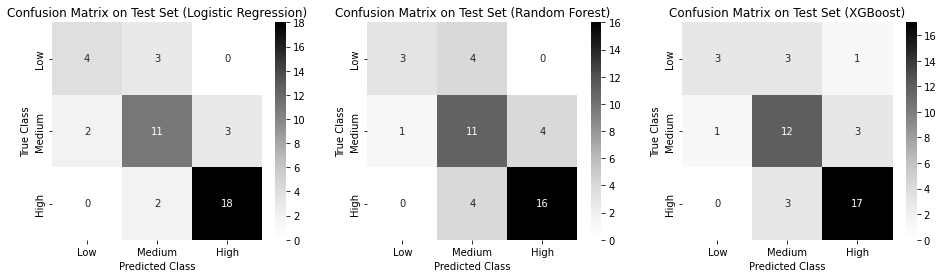

In [65]:
label_map = {0: 'Low', 1: 'Medium', 2: 'High'}

plt.subplots(figsize=(16, 4))
ax1 = plt.subplot(1, 3, 1)
confMat=confusion_matrix(y_test, pred_test_logist)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax1=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax1.set_title('Confusion Matrix on Test Set (Logistic Regression)', fontsize=12)
ax1.set_xlabel('Predicted Class', fontsize=10)
ax1.set_ylabel('True Class', fontsize=10)

ax2 = plt.subplot(1, 3, 2)
confMat=confusion_matrix(y_test, pred_test_rf)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax2=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax2.set_title('Confusion Matrix on Test Set (Random Forest)', fontsize=12)
ax2.set_xlabel('Predicted Class', fontsize=10)
ax2.set_ylabel('True Class', fontsize=10)

ax3 = plt.subplot(1, 3, 3)
confMat=confusion_matrix(y_test, pred_test_xgbm)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax3=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax3.set_title('Confusion Matrix on Test Set (XGBoost)', fontsize=12)
ax3.set_xlabel('Predicted Class', fontsize=10)
ax3.set_ylabel('True Class', fontsize=10)

plt.show()